**We first install all the required libraries**

In [1]:
# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Handling Imbalanced Data 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Jupyter Notebook Configuration
%matplotlib inline
sns.set_style("darkgrid")


**TASK 1: DATA LOADING AND INITIAL EXPLORATION**

**Import the dataset from excel**

In [2]:
df = pd.read_excel("titanic3.xls")

# Display the first few rows to make sure the excel was readed correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


• Now we are going to perform some purely statistical operations to understand better the entity of the dataset, including outliers, missing data, etc.

In [3]:
df.head()  

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
df.describe() 

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [5]:
df.isnull().sum() # Check how many values are missing

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

• Let's understand what percentage of people actually survived by seeing it visually

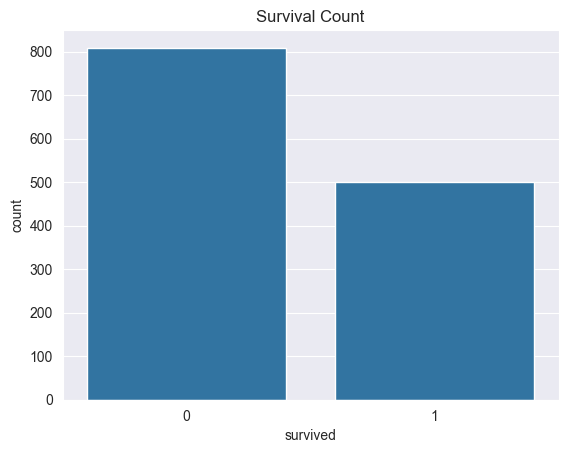

In [6]:
sns.countplot(x="survived", data=df)
plt.title("Survival Count")
plt.show()

In [7]:
# Count duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


• Let's now see the age distribution

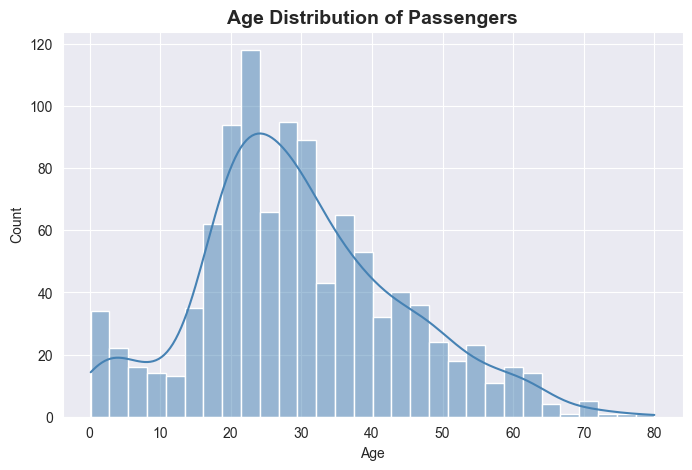

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], bins=30, kde=True, color="steelblue")
plt.title("Age Distribution of Passengers", fontsize=14, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


• Now let's see if there are any correlation between different classes of the dataset

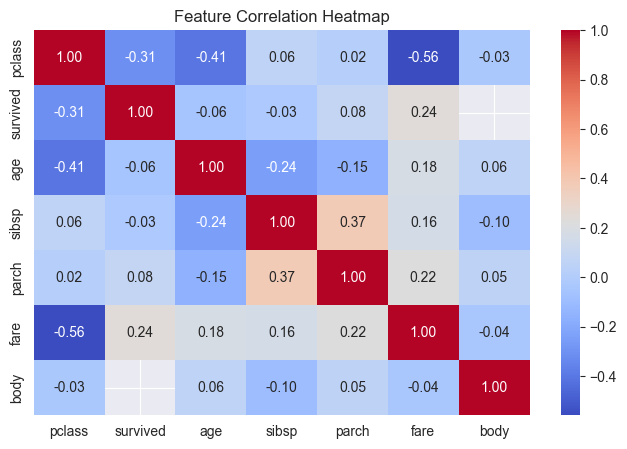

In [9]:
plt.figure(figsize=(8,5))

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Create the heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Feature Correlation Heatmap")
plt.show()


From this we can derive different intuitions which for now I think are the most relevant information:

- There is a strong negative correlation (-0.56) between the fare and the class of the passenger. This makes perfectly sense since the higher the class ( 1st, 2nd, 3rd...), the less you pay.

- There is a moderate positive correlation (0.37) between the people who have siblings/spouses and the people who have parents/children, which again makes perfectly sense.

- There is one last notable correlation, the one between the fare and the people that survived, which is positive (0.24). From here we can deduce that the people that payed more, so the people that were in higher classes were more likely to survive.

**TASK 2: MANAGING MISSING VALUES**

As we saw earlier, there are several missing values, and we have to deal with them. 
Let's see the data again:

In [10]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In order to handle this missing values, we have to take different approach for each of the columns:
- **Age**: This is an important factor when determing whether a person survives or not. To fill in the missing values we will be using median imputation. We use this instead of the mean to rule out outliers such as very old people and very young people.

- **Fare**: Only one value is missing so we will just fill that with the median again.

- **Cabin**: The vast majority of it is missing, however this is a really important feature since the higher blocks (A, B and C) had easier access to boats while lower ones (D, E, F and so on) were further and had a harder time escaping. For this reason we are going to drop the number of the cabins and just keep the letter of the block (for example C85-->C), and since we cannot assign random rooms to the missing people we are just going to assign the letter U for Unknown.

- **Embarked**: This is a categorical value and only 2 are missing so we are going to use the mode and assign to them the most common value. We are going to keep the data since we don't know whether this is significant or not.

- **Boat**: A lot of these are missing, furthermore, having or not having a assigned boat it is too closely linked to survival. In addition, passengers were not assigned or not a boat in advance, the decision was taken in that precise moment (favoring women, children, elderly, ecc...). That is why is wise to drop this column. However we first have to prove our point.

- **Body**: Since this data is taken after the disaster and has nothing to do with the prediction, we can drop this column.

- **Destination**: Roughly half is missing, and since we don't know if is relevant or not we are just going to assign U for Unknown to the missing ones.

In [11]:
# Age & Fare: Use median imputation
df['age'].fillna(df['age'].median(), inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)

# Fill missing embarked values with the most common value
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

# Drop the 'body' column
df.drop(columns=['body'], inplace=True)

# Process 'cabin' - Extract first letter and fill missing values
df['cabin'] = df['cabin'].astype(str).str[0]  # Keep only the first letter
df['cabin'].fillna("U", inplace=True)  # "U" for Unknown cabins

# Home.dest: Fill missing values with "Unknown"
df['home.dest'].fillna("Unknown", inplace=True)

/var/folders/_x/r_w1x7px315bdr1btbx3zq6w0000gp/T/ipykernel_10033/1766624976.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/var/folders/_x/r_w1x7px315bdr1btbx3zq6w0000gp/T/ipykernel_10033/1766624976.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

Checking now if the correlation between having a boat and surviving is too high:

In [12]:
# We are creating a new column called "boat_assigned" that will be 1 if the passenger was assigned a boat and 0 if not
df['boat_assigned'] = df['boat'].notna().astype(int)

# Check how strongly 'boat_assigned' is related to 'survived'
correlation = df['boat_assigned'].corr(df['survived'])
print(f"Correlation between boat_assigned and survived: {correlation}")

Correlation between boat_assigned and survived: 0.9481900695821421


This is definitely too high. The model would rely too much on this. We have to drop it

In [13]:
# Drop the 'boat' column
df.drop(columns=['boat_assigned'], inplace=True)
df.drop(columns=['boat'], inplace=True)

Let's now check if it worked correctly by checking again the missing values and the heatmap:

In [14]:
df.isnull().sum()

pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
cabin        0
embarked     0
home.dest    0
dtype: int64

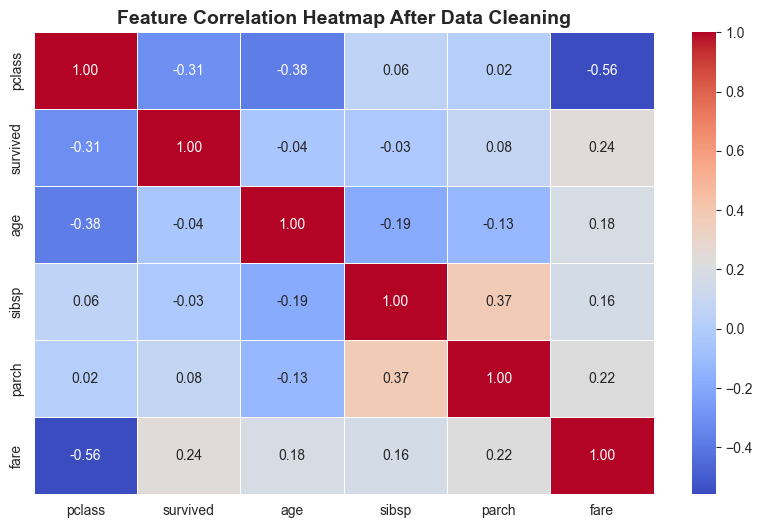

In [15]:

numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap After Data Cleaning", fontsize=14, fontweight="bold")
plt.show()

Everything seemed to work well. We can move on.

**TASK 3: ENCODING CATEGORICAL VARIABLES**

The first step to do this is first of all identify what categorical variables do we have. These are: Sex, Embarked, Cabin and Home.dest. The first 3 are fine, however, regarding Home.dest, we have a problem and is that since when we encode with OneHotEncoder we make the database larger since we are separating each category and making it a vecor, when we have many options, even though they are finite, it could overload the dataset. For this reason we are going to esclude to encode Home.dest.
To avoid this problem also with the first three variables, we are going to drop the first type, to avoid redundancy and minimize the used space. This is because for example with sex, if you are not a male you can only be a female (maybe nowadays someone would say otherwise but we will exclude that in our case!!), so there is no point of having a column for both. Let's just make it for that one and if you are not one you are the other.

In [16]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S,"Montreal, PQ / Chesterville, ON"


In [ ]:
# Define categorical variables
categorical_cols = ["sex", "embarked", "cabin"]


encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' avoids redundancy

# Apply OneHotEncoder and transform into DataFrame
encoded_array = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the new encoded columns with the original dataset
df = pd.concat([df, encoded_df], axis=1)

# Drop the original categorical columns (we now have their numerical representations)
df.drop(columns=categorical_cols, inplace=True)

# Display the first few rows to verify the transformation
df.head()

,pclass,survived,name,age,sibsp,parch,ticket,fare,home.dest,sex_male,embarked_Q,embarked_S,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T,cabin_n
0,1,1,"Allen, Miss. Elisabeth Walton",29.0000,0,0,24160,211.3375,"St Louis, MO",0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,"Allison, Master. Hudson Trevor",0.9167,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,"Allison, Miss. Helen Loraine",2.0000,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",30.0000,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1,2,113781,151.5500,"Montreal, PQ / Chesterville, ON",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   survived    1309 non-null   int64  
 2   name        1309 non-null   object 
 3   age         1309 non-null   float64
 4   sibsp       1309 non-null   int64  
 5   parch       1309 non-null   int64  
 6   ticket      1309 non-null   object 
 7   fare        1309 non-null   float64
 8   home.dest   1309 non-null   object 
 9   sex_male    1309 non-null   float64
 10  embarked_Q  1309 non-null   float64
 11  embarked_S  1309 non-null   float64
 12  cabin_B     1309 non-null   float64
 13  cabin_C     1309 non-null   float64
 14  cabin_D     1309 non-null   float64
 15  cabin_E     1309 non-null   float64
 16  cabin_F     1309 non-null   float64
 17  cabin_G     1309 non-null   float64
 18  cabin_T     1309 non-null   float64
 19  cabin_n     1309 non-null  

As we can see, OneHotEncoder dropped 'sex_female', 'embarked_C', 'cabin_A' and changed the name Unknown for cabins to cabin_n.

Now our categorical variables are encoded. We can now proceed.